In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm, trange
tqdm.pandas()

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
data = pd.read_csv('data.csv')
print(data.shape)
data.head()

(223549, 10)


,comment_text,identity_hate,insult,obscene,severe_toxic,threat,toxic,positive,len,clean_text
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,43,explanation edits username hardcore metallica ...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,17,aww matches background colour seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,42,hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,113,make real suggestions improvement wondered sec...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,13,sir hero chance remember page


In [3]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
print(data.shape)

(223162, 10)


In [4]:
labels= ['identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat', 'toxic']

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

In [6]:
import nltk, re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [7]:
class TextCleaner(BaseEstimator):
    
    def __init__(self, rsw=True, stm=False, lem=False):
        
        self.rsw = rsw
        self.stm = stm
        self.lem = lem
        
        self.stop_words = set(nltk.corpus.stopwords.words('english'))
        self.ps = PorterStemmer()
        self.wnl = WordNetLemmatizer()
        
    def fit(self, x, y=None):
        return self
    
    def spell_correct(self, text):
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"what's", "what is ", text) 
        text = re.sub(r"'s", " ", text)
        text = re.sub(r"'ve", " have ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"'re", " are ", text)
        text = re.sub(r"'d", " would ", text)
        text = re.sub(r"'ll", " will ", text)
        text = re.sub(r"s", "0", text)    
        return text

    def remove_url(self, text):
        URL_REGEX = re.compile(r'''((http[s]?://)[^ <>'"{}|\^`[\]]*)''')
        return URL_REGEX.sub(r' ', text)

    def remove_handles(self, text):
        HANDLES_REGEX = re.compile(r'@\S+')
        return HANDLES_REGEX.sub(r' ', text)

    def remove_incomplete_last_word(self, text):
        INCOMPLETE_LAST_WORD_REGEX = re.compile(r'\S+…')
        return INCOMPLETE_LAST_WORD_REGEX.sub(r' ', text )

    def remove_punc(self, text):
        return re.sub(r"\W", ' ', text)

    def remove_num(self, text):
        return re.sub(r"\d", ' ', text)

    def remove_extra_spaces(self, text):
        return re.sub(r"\s+", ' ', text).strip()

    def remove_shortwords(self, text): 
        return ' '.join(word for word in text.split() if len(word) > 2)

    def lower_case(self, text):
        return  text.lower()

    def remove_stopwords(self, text):
        return ' '.join(word for word in text.split() if word not in self.stop_words)

    def ps_stem(self, text):
        return ' '.join(self.ps.stem(word) for word in text.split())

    def wnl_lemmatize(self, text):
        return ' '.join(self.wnl.lemmatize(word) for word in text.split())

    def clean(self, x, rsw, stm, lem):
        x = str(x)
        x = self.remove_url(str(x))
        x = self.lower_case(str(x))
        x = self.spell_correct(str(x))
        x = self.remove_punc(str(x))
        x = self.remove_num(str(x))
        x = self.remove_extra_spaces(str(x))
        x = self.remove_shortwords(str(x))

        if rsw:
            x = self.remove_stopwords(str(x))
        if stm:
            x = self.ps_stem(str(x))
        if lem:
            x = self.wnl_lemmatize(str(x))
        return x
    
    def transform(self, x):
        x = map(lambda text: self.clean(text, self.rsw, self.stm, self.lem)  , x)
        x = np.array(list(x))
        return x

In [8]:
cleaner = TextCleaner()
vectorizer = TfidfVectorizer(sublinear_tf=True)

p = Pipeline([
    ('cleaner', cleaner), 
    ('vectorizer', vectorizer)
])

p.fit(data['comment_text'])
vects = p.transform(data['comment_text'])

target = data[labels].values

In [9]:
print('X shape', vects.shape)
print('Y shape', target.shape)

X shape (223162, 190823)
Y shape (223162, 6)


In [10]:
from utils.ml import train_model_one_vs_rest

In [11]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, BaggingClassifier

Mean Score 0.8428 +- 0.0078
Mean Accuracy 0.8954 +- 0.0027


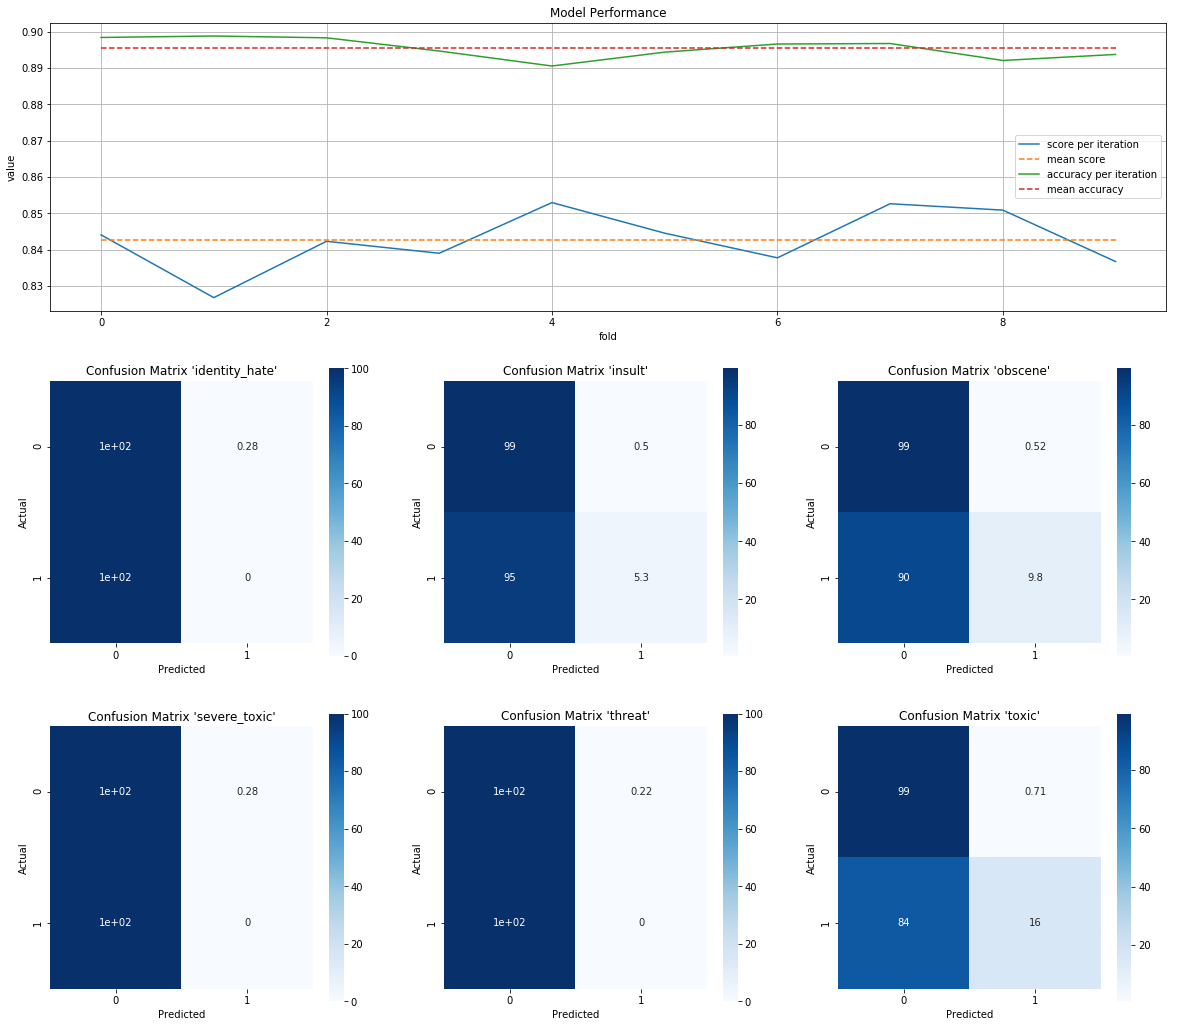

In [12]:
model = MultinomialNB()
mnb_performance, mnb_cm, mnb_model = train_model_one_vs_rest(model, vects, target, labels)
print('Mean Score', round(np.mean(mnb_performance['score']), 4), '+-', round(np.std(mnb_performance['score']), 4))
print('Mean Accuracy', round(np.mean(mnb_performance['accuracy']), 4), '+-', round(np.std(mnb_performance['accuracy']), 4))

Mean Score 0.9772 +- 0.0013
Mean Accuracy 0.8639 +- 0.0027


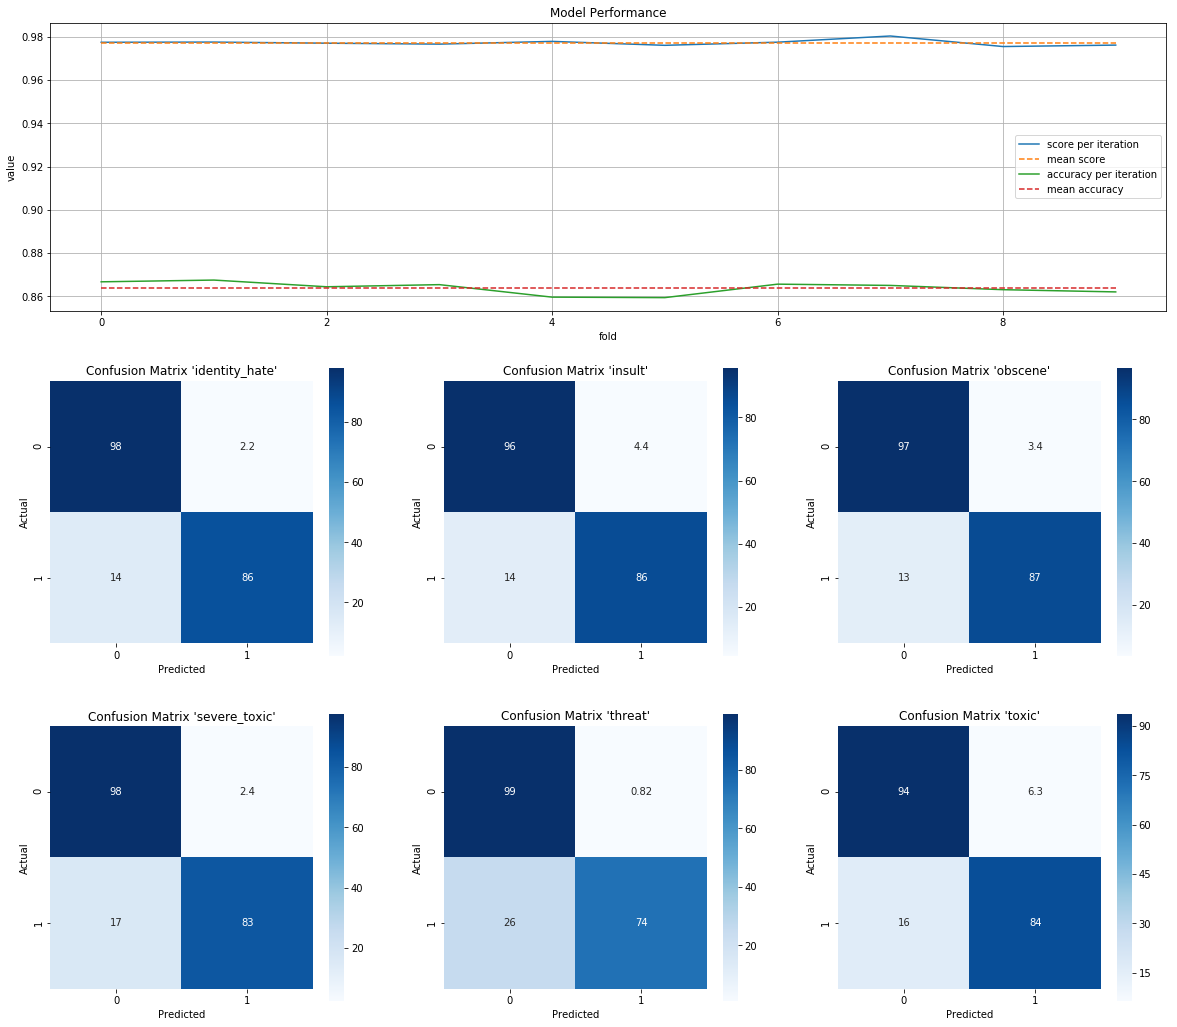

In [13]:
model = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1_00_000, random_state=101, warm_start=True)
lr_performance, lr_cm, lr_model = train_model_one_vs_rest(model, vects, target, labels)
print('Mean Score', round(np.mean(lr_performance['score']), 4), '+-', round(np.std(lr_performance['score']), 4))
print('Mean Accuracy', round(np.mean(lr_performance['accuracy']), 4), '+-', round(np.std(lr_performance['accuracy']), 4))

Mean Score 0.9765 +- 0.0012
Mean Accuracy 0.8506 +- 0.0029


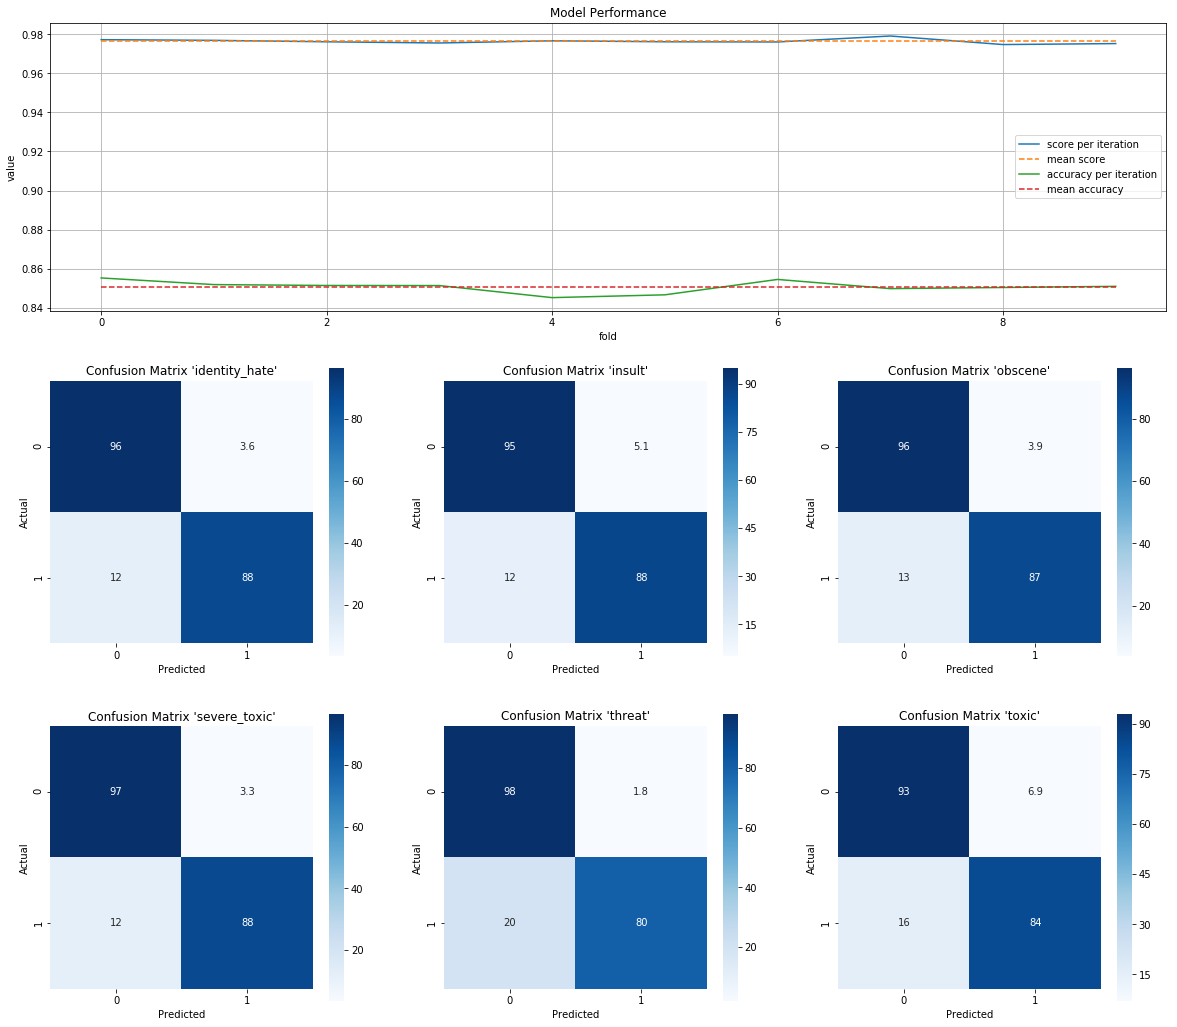

In [14]:
model = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1_00_000, random_state=101, warm_start=True, C=0.1)
lr01_performance, lr01_cm, lr01_model = train_model_one_vs_rest(model, vects, target, labels)
print('Mean Score', round(np.mean(lr01_performance['score']), 4), '+-', round(np.std(lr01_performance['score']), 4))
print('Mean Accuracy', round(np.mean(lr01_performance['accuracy']), 4), '+-', round(np.std(lr01_performance['accuracy']), 4))

In [15]:
import pickle

In [17]:
pickle.dump([p, lr01_model], open('OneVsRest.pkl', 'wb'))